In [1]:
import pandas as pd
import numpy as np

f_gen = '/home/data/nbc/physics-learning/data/behavioral-data/analyses/physics-learning-behavioral/datafiles/c123456-demographics.txt'
outfile_full =  'reas_accuracy_by_gender.txt'
outfile_pre =  'reas_accuracy_by_gender_pre.txt'
outfile_post =  'reas_accuracy_by_gender_post.txt'

cols = ['Subject', 'Session', 'ContrastValue', 'C1.ACC', 'C1.RT']

df_gen = pd.read_csv(f_gen, sep='\t')

In [2]:
from glob import glob
from os.path import basename, join

rcsv_dir = '/home/data/nbc/physics-learning/data/behavioral-data/rcsv/'
subjects = glob(join(rcsv_dir, '*'))
subjects = [basename(s) for s in subjects]
subjects = sorted([s for s in subjects if s.isdigit() and len(s)==3])
sessions = ['session-0', 'session-1']
all_dfs = []
for s in subjects:
    for ss in sessions:
        files = sorted(glob(join(rcsv_dir, s, ss, 'REAS/REAS_*.csv')))
        if len(files) > 0:
            dfs = [pd.read_csv(f) for f in files]
            df = pd.concat(dfs, axis=0)
            df = df.loc[df['ContrastValue']=='reasoning']
            df2 = pd.DataFrame(df.mean()[['Subject', 'Session', 'C1.ACC']]).transpose()
            mean_df = df.groupby('C1.ACC').mean()
            if 1 in mean_df.index:
                df2.loc[0, 'Mean Correct RT'] = mean_df.loc[1, 'C1.RT']
            else:
                df2.loc[0, 'Mean Correct RT'] = np.nan
            
            if 0 in mean_df.index:
                df2.loc[0, 'Mean Incorrect RT'] = mean_df.loc[0, 'C1.RT']
            else:
                df2.loc[0, 'Mean Incorrect RT'] = np.nan
            
            all_dfs.append(df2)

full_df = pd.concat(all_dfs, axis=0)
full_df['Subject'] = full_df['Subject'].astype(int).astype(str)
full_df['Session'] = full_df['Session'].astype(int).astype(str)
full_df['Session'] = full_df['Session'].map({'1': 'pre',
                                             '2': 'post'})
full_df = full_df.rename(columns={'C1.ACC': 'Mean Reasoning Accuracy'})
pre_df = full_df.loc[full_df['Session']=='pre']
post_df = full_df.loc[full_df['Session']=='post']

In [3]:
# set key and drop irrelevant columns
df_gen = df_gen.rename(columns={'PID': 'Subject'})
df_gen['Subject'] = df_gen['Subject'].astype(str)

# merge data frames on key and sort
out_df_full = full_df.merge(df_gen[['Subject', 'Gender']], on=['Subject'])
out_df_pre = pre_df.merge(df_gen[['Subject', 'Gender']], on=['Subject'])
out_df_post = post_df.merge(df_gen[['Subject', 'Gender']], on=['Subject'])
#df = df.sort_values(['Session','Subject'], ascending=[False,True])

# write new file
out_df_full.to_csv(outfile_full,sep='\t',header=True,index=False)
out_df_pre.to_csv(outfile_pre,sep='\t',header=True,index=False)
out_df_post.to_csv(outfile_post,sep='\t',header=True,index=False)

In [4]:
#analysis_df_pre = pd.read_csv('/home/data/nbc/physics-learning/data/behavioral-data/analyses/physics-learning-behavioral/datafiles/reas_accuracy_by_gender_pre.txt', sep='\t')
#analysis_df_post = pd.read_csv('/home/data/nbc/physics-learning/data/behavioral-data/analyses/physics-learning-behavioral/datafiles/reas_accuracy_by_gender_post.txt', sep='\t')
analysis_df_full = pd.read_csv('/home/data/nbc/physics-learning/data/behavioral-data/analyses/physics-learning-behavioral/datafiles/reas_accuracy_by_gender.txt', sep='\t')
analysis_df_full.head()

,Subject,Session,Mean Reasoning Accuracy,Mean Correct RT,Mean Incorrect RT,Gender
0,101,pre,0.750,3578.633333,3392.800000,F
1,101,post,0.650,3990.653846,3552.571429,F
2,102,pre,0.900,2555.305556,2294.500000,M
3,102,post,0.900,2846.472222,4246.750000,M
4,103,pre,0.975,3276.102564,0.000000,M


In [5]:
# drop unmatched data from dfs
print('unmatched df size', analysis_df_full.shape)

unmatched = []
for subid in analysis_df_full['Subject'].unique():    
    row = analysis_df_full.loc[analysis_df_full['Subject'] == subid, 'Mean Reasoning Accuracy'].index
    if len(row) == 1:
        unmatched.append(row)
for i in unmatched:
    analysis_df_full.drop(i, inplace = True)

print('matched df size', analysis_df_full.shape)

analysis_df_pre = analysis_df_full[analysis_df_full['Session']=='pre']
analysis_df_post = analysis_df_full[analysis_df_full['Session']=='post']

('unmatched df size', (226, 6))
('matched df size', (210, 6))


/home/data/nbc/nbclab-env/env-py2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


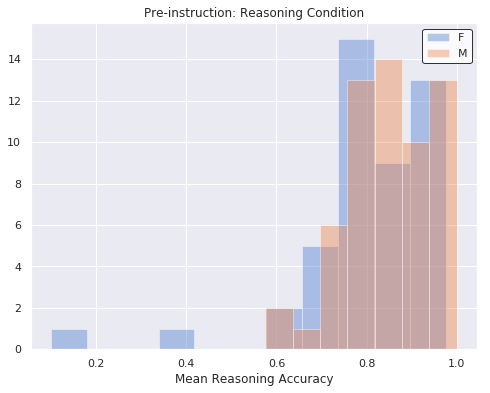

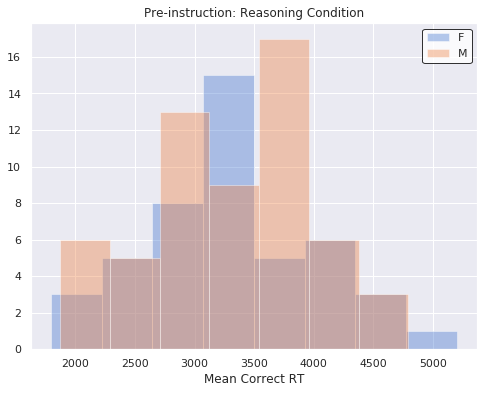

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="muted", color_codes=True)

# reas acc, pre
fig, ax = plt.subplots(figsize=(8, 6))
for sex in analysis_df_pre['Gender'].unique():
    sex_df = analysis_df_pre.loc[analysis_df_pre['Gender']==sex]
    sns.distplot(sex_df['Mean Reasoning Accuracy'], ax=ax, kde=False, 
                 label=sex)

legend = ax.legend(frameon=True)
plt.title('Pre-instruction: Reasoning Condition')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig('reas_mean_accuracy_pre.png', dpi=400)

# reas rt, pre
fig, ax = plt.subplots(figsize=(8, 6))
for sex in analysis_df_pre['Gender'].unique():
    sex_df = analysis_df_pre.loc[analysis_df_pre['Gender']==sex]
    sns.distplot(sex_df['Mean Correct RT'], ax=ax, kde=False, 
                 label=sex)

legend = ax.legend(frameon=True)
plt.title('Pre-instruction: Reasoning Condition')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig('reas_mean_rt_pre.png', dpi=400)

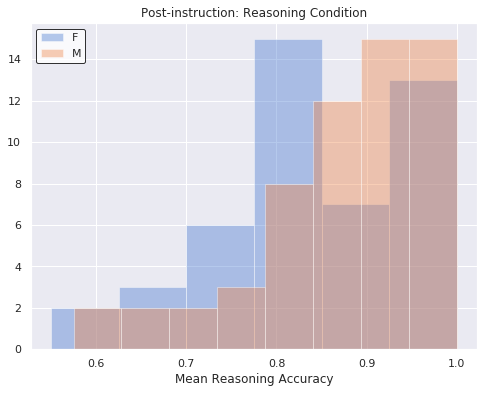

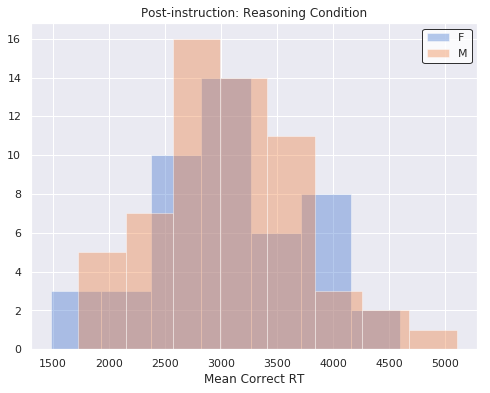

In [7]:
sns.set(palette="muted", color_codes=True)

# reas acc, post
fig, ax = plt.subplots(figsize=(8, 6))
for sex in analysis_df_post['Gender'].unique():
    sex_df = analysis_df_post.loc[analysis_df_post['Gender']==sex]
    sns.distplot(sex_df['Mean Reasoning Accuracy'], ax=ax, kde=False, 
                 label=sex)

legend = ax.legend(frameon=True)
plt.title('Post-instruction: Reasoning Condition')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig('reas_mean_accuracy_post.png', dpi=400)

# reas rt, post
fig, ax = plt.subplots(figsize=(8, 6))
for sex in analysis_df_post['Gender'].unique():
    sex_df = analysis_df_post.loc[analysis_df_post['Gender']==sex]
    sns.distplot(sex_df['Mean Correct RT'], ax=ax, kde=False, 
                 label=sex)

legend = ax.legend(frameon=True)
plt.title('Post-instruction: Reasoning Condition')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig('reas_mean_rt_post.png', dpi=400)

In [8]:
from scipy.stats import ttest_ind, ttest_rel

## Accuracy By Gender

# Get means for pre and post, all conditions
mean_df_reas_pre = analysis_df_pre.groupby('Gender').mean()
mean_df_reas_post = analysis_df_post.groupby('Gender').mean()

# Get SDs for pre and post, all conditions
sd_df_reas_pre = analysis_df_pre.groupby('Gender').std()
sd_df_reas_post = analysis_df_post.groupby('Gender').std()

# Accuracies
acc_m_reas_pre = analysis_df_pre[analysis_df_pre['Gender']=='M']
acc_f_reas_pre = analysis_df_pre[analysis_df_pre['Gender']=='F']

acc_m_reas_post = analysis_df_post[analysis_df_post['Gender']=='M']
acc_f_reas_post = analysis_df_post[analysis_df_post['Gender']=='F']

# t tests
tstat_reas_pre = ttest_ind(acc_m_reas_pre['Mean Reasoning Accuracy'], acc_f_reas_pre['Mean Reasoning Accuracy'])
tstat_reas_post = ttest_ind(acc_m_reas_post['Mean Reasoning Accuracy'], acc_f_reas_post['Mean Reasoning Accuracy'])
tstat_rt_pre = ttest_ind(acc_m_reas_pre['Mean Correct RT'], acc_f_reas_pre['Mean Correct RT'])
tstat_rt_post = ttest_ind(acc_m_reas_post['Mean Correct RT'], acc_f_reas_post['Mean Correct RT'])

print '\n Pre-instruction: \n General Reasoning Accuracy By', mean_df_reas_pre['Mean Reasoning Accuracy']
print 'P val:', tstat_reas_pre.pvalue
print '\n Pre-instruction: \n General Reasoning Accuracy SD By', sd_df_reas_pre['Mean Reasoning Accuracy']
print '\n Pre-instruction: \n General Reasoning RT By', mean_df_reas_pre['Mean Correct RT']
print 'P val:', tstat_rt_pre.pvalue

print '\n Post-instruction: \n General Reasoning Accuracy By', mean_df_reas_post['Mean Reasoning Accuracy']
print 'P val:', tstat_reas_post.pvalue
print '\n Post-instruction: \n General Reasoning Accuracy SD By', sd_df_reas_post['Mean Reasoning Accuracy']
print '\n Post-instruction: \n General Reasoning RT By', mean_df_reas_post['Mean Correct RT']
print 'P val:', tstat_rt_post.pvalue


 Pre-instruction: 
 General Reasoning Accuracy By Gender
F    0.801630
M    0.849576
Name: Mean Reasoning Accuracy, dtype: float64
P val: 0.05300773760081089

 Pre-instruction: 
 General Reasoning Accuracy SD By Gender
F    0.154237
M    0.095309
Name: Mean Reasoning Accuracy, dtype: float64

 Pre-instruction: 
 General Reasoning RT By Gender
F    3293.495701
M    3279.435457
Name: Mean Correct RT, dtype: float64
P val: 0.9182857053133547

 Post-instruction: 
 General Reasoning Accuracy By Gender
F    0.835870
M    0.866525
Name: Mean Reasoning Accuracy, dtype: float64
P val: 0.11682812430736506

 Post-instruction: 
 General Reasoning Accuracy SD By Gender
F    0.104170
M    0.093956
Name: Mean Reasoning Accuracy, dtype: float64

 Post-instruction: 
 General Reasoning RT By Gender
F    3063.505892
M    3073.171208
Name: Mean Correct RT, dtype: float64
P val: 0.9418373192199831


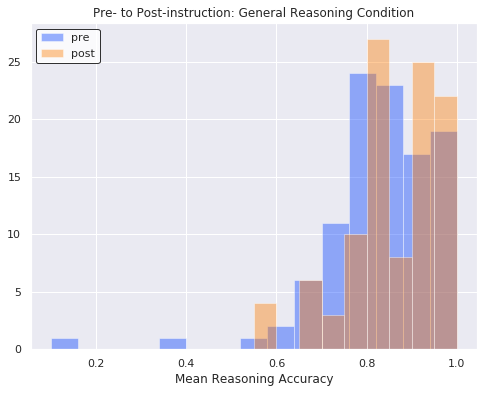

In [9]:
# plot accuracy pre and post
sns.set(palette="bright", color_codes=True)

#sns.palplot(sns.color_palette("Set2", 10))
fig, ax = plt.subplots(figsize=(8, 6))
for sess in analysis_df_full['Session'].unique():
    sess_df = analysis_df_full.loc[analysis_df_full['Session']==sess]
    sns.distplot(sess_df['Mean Reasoning Accuracy'], ax=ax, kde=False, 
                 label=sess)

legend = ax.legend(frameon=True)
plt.title('Pre- to Post-instruction: General Reasoning Condition')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig('reas_mean_accuracy_pre2post.png', dpi=400)

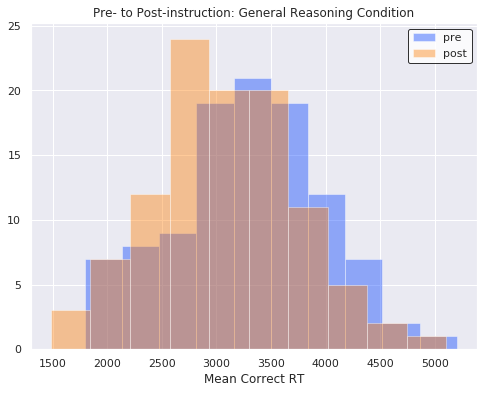

In [10]:
# plot rt pre and post
sns.set(palette="bright", color_codes=True)

#sns.palplot(sns.color_palette("Set2", 10))
fig, ax = plt.subplots(figsize=(8, 6))
for sess in analysis_df_full['Session'].unique():
    sess_df = analysis_df_full.loc[analysis_df_full['Session']==sess]
    sns.distplot(sess_df['Mean Correct RT'], ax=ax, kde=False, 
                 label=sess)

legend = ax.legend(frameon=True)
plt.title('Pre- to Post-instruction: General Reasoning Condition')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig('reas_mean_RT_pre2post.png', dpi=400)

In [14]:
from scipy.stats import shapiro

#Shapiro-Wilk Normality Test
cond = 'Reasoning'
meas = 'Accuracy'
data1 = analysis_df_pre['Mean {0} {1}'.format(cond,meas)]
data2 = analysis_df_post['Mean {0} {1}'.format(cond,meas)]
datalist = [data1, data2]

# normality test
for i, data in enumerate(datalist):
    stat, p = shapiro(data)
    if i == 0:
        print('Reas Accuracy Pre')
    elif i == 1:
        print('Reas Accuracy Post')
    else:
        print('something went wrong')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

Reas Accuracy Pre
Statistics=0.824, p=0.000
Sample does not look Gaussian (reject H0)
Reas Accuracy Post
Statistics=0.936, p=0.000
Sample does not look Gaussian (reject H0)


In [19]:
## Accuracy and RT t-tests post to pre

from scipy.stats import wilcoxon

# Get mean for pre and post
mean_df_reas_full = analysis_df_full.groupby('Session').mean()
sem_df_reas_full = analysis_df_full.groupby('Session').sem()

# Accuracies
acc_reas_pre = analysis_df_full[analysis_df_full['Session']=='pre']
acc_reas_post = analysis_df_full[analysis_df_full['Session']=='post']

# Response Times
rt_reas_pre = analysis_df_full[analysis_df_full['Session']=='pre']
rt_reas_post = analysis_df_full[analysis_df_full['Session']=='post']

# t tests (for normal data)
tstat_reas_acc = ttest_rel(acc_reas_pre['Mean Reasoning Accuracy'], acc_reas_post['Mean Reasoning Accuracy'])
tstat_reas_rt = ttest_rel(rt_reas_pre['Mean Correct RT'], rt_reas_post['Mean Correct RT'])

# Wilcoxon sign-ranked test (for non-normal data)
data1, data2 = acc_reas_pre['Mean Reasoning Accuracy'], acc_reas_post['Mean Reasoning Accuracy']
stat, p = wilcoxon(data1, data2)

print '\n Pre- to Post-Instruction Accuracy: \n General Reasoning Condition By', mean_df_reas_full['Mean Reasoning Accuracy']
print 'T-Test P val:', tstat_reas_acc.pvalue
print 'Wilcoxon P val:', p
print '\n Pre- to Post-Instruction Accuracy SEM: \n General Reasoning Condition By', sem_df_reas_full['Mean Reasoning Accuracy']

print '\n Pre- to Post-Instruction RT: \n General Reasoning Condition By', mean_df_reas_full['Mean Correct RT']
print 'P val:', tstat_reas_rt.pvalue


 Pre- to Post-Instruction Accuracy: 
 General Reasoning Condition By Session
post    0.853095
pre     0.828571
Name: Mean Reasoning Accuracy, dtype: float64
T-Test P val: 0.02764060868215129
Wilcoxon P val: 0.05291244043774125

 Pre- to Post-Instruction Accuracy SEM: 
 General Reasoning Condition By Session
post    0.009687
pre     0.012317
Name: Mean Reasoning Accuracy, dtype: float64

 Pre- to Post-Instruction RT: 
 General Reasoning Condition By Session
post    3068.936879
pre     3285.595183
Name: Mean Correct RT, dtype: float64
P val: 1.714550955230696e-05
